# Modelo predictivo  (Espacial) de siniestros en las calles de Santiago
- UDD - MDS18 - BDA
- Final Delivery 
- 50_Final_Geo_Project_Model_Validation_Analysis
- 09 August 2019

**CHANGE KERNEL:** geo_p_3_7

## Datasets (Landing)

###  CONASET
http://mapas-conaset.opendata.arcgis.com/search?groupIds=fca1f61c6556499db843c09cc80c70c0

Estas capas contienen la geocodificación de los accidentes de tránsito registrados en la Región Metropolitana entre los años 2013 y 2018. Contiene los detalles de fecha (en la mayoria solo día/mes), tipo de accidente, causa basal del accidente, dirección donde ocurrió el accidente, fallecidos y lesionados según gravedad. 
- [Siniestros RM - 2013](http://mapas-conaset.opendata.arcgis.com/datasets/12cb58c27a2846dfa60cf629a14d611a_0)
- [Siniestros RM - 2014](http://mapas-conaset.opendata.arcgis.com/datasets/aa5b5322bc564b809aa29c70658b9cf9_0)
- [Siniestros RM - 2015](http://mapas-conaset.opendata.arcgis.com/datasets/dafa26dbce99467985596d8a58216b79_0)
- [Siniestros RM - 2016](http://mapas-conaset.opendata.arcgis.com/datasets/32ee49c703b840b885b9c80b37ae72d0_0)
- [Siniestros RM - 2017](http://mapas-conaset.opendata.arcgis.com/datasets/907addac92b74e3fa30d40edb72d1813_0)
- [Siniestros RM - 2018](http://mapas-conaset.opendata.arcgis.com/datasets/3a084373b58b45d0ae01d9c14a231cf8_0)

### OpenStreetMap
- POI and streets of Santiago
<br><br>
http://download.geofabrik.de/south-america/chile.html

## Main Libraries

In [1]:
from math import radians, cos, sin, asin, sqrt, atan2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns
import folium
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, MultiLineString
import shapefile as shp
import gpd_lite_toolbox as glt
from gpd_lite_toolbox.utils_carto import m_plot_dataframe, m_plot_multipolygon
import warnings
warnings.filterwarnings('ignore')

In [28]:
sns.set(context='paper', style='ticks', palette='inferno')
sns.mpl.rc("figure", figsize=(10, 6))
mpl.rcParams['figure.dpi']= 150

---

## Analyzing the Crash Prevision 2018 Dataset
**Model will be split in train/test (80%/20%), using 2013-2017 Dataset and Validated with 2018 Events**
- Dataset from Notebook: 40_Final_Geo_Project_PySpark_MLib_RF_GBT_Models_Gr100_dataset-2013-17_val_18

In [3]:
cp_2018 = pd.read_csv("../model/Crash_Prevision_2018.csv")
cp_2018.shape

(63029, 8)

In [4]:
del cp_2018['Unnamed: 0']
del cp_2018['rawPrediction']

In [5]:
def get_prob(row):
    return (float(row.probability[1:6]))

In [6]:
cp_2018['probability'] = cp_2018.apply(get_prob, axis=1)

In [8]:
cp_2018.head(4)

,id,X,Y,label,probability,prediction
0,0,-70.824738,-33.557697,0.0,0.956,0.0
1,1,-70.823831,-33.556787,0.0,0.956,0.0
2,2,-70.823831,-33.557697,0.0,0.956,0.0
3,3,-70.822922,-33.556787,0.0,0.956,0.0


In [9]:
cp_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63029 entries, 0 to 63028
Data columns (total 6 columns):
id             63029 non-null int64
X              63029 non-null float64
Y              63029 non-null float64
label          63029 non-null float64
probability    63029 non-null float64
prediction     63029 non-null float64
dtypes: float64(5), int64(1)
memory usage: 2.9 MB


In [10]:
sin = cp_2018[cp_2018.label == 1.0]

In [11]:
sin.probability.describe()

count    6687.000000
mean        0.605551
std         0.298729
min         0.025000
25%         0.344000
50%         0.685000
75%         0.857000
max         0.966000
Name: probability, dtype: float64

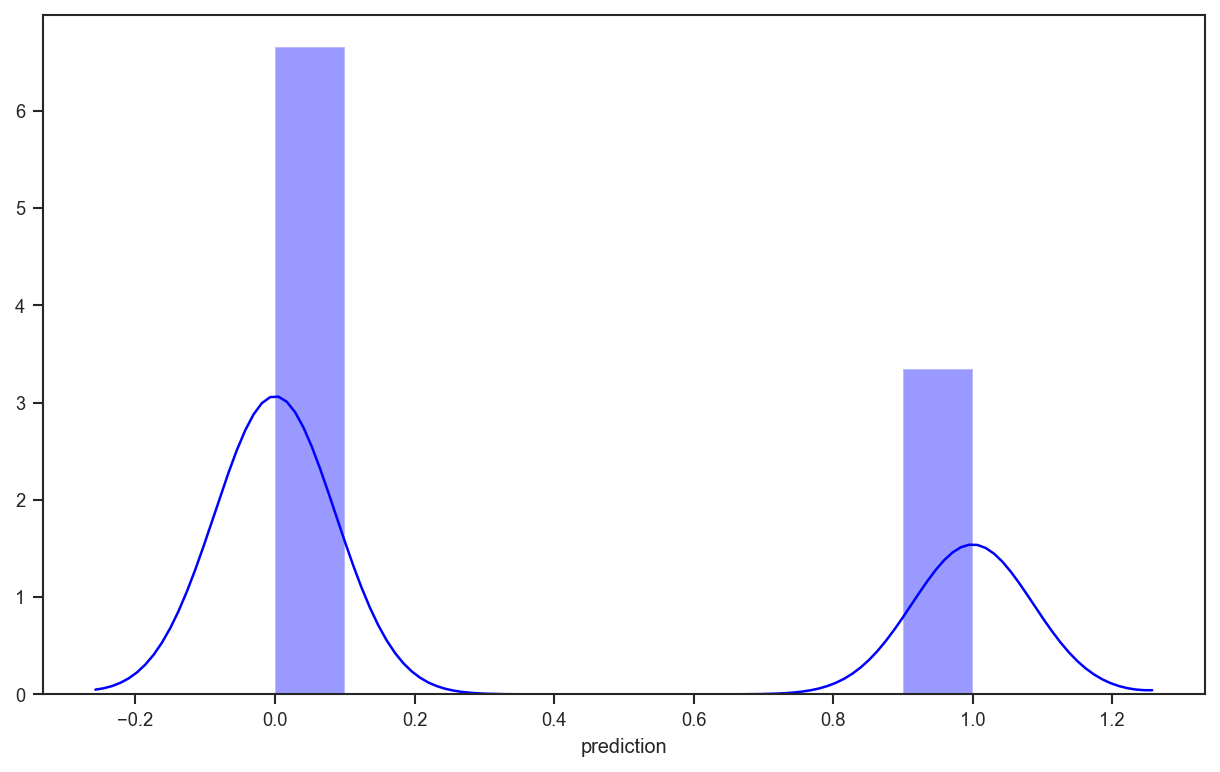

In [12]:
sns.distplot(sin.prediction,  hist=True, color="b")

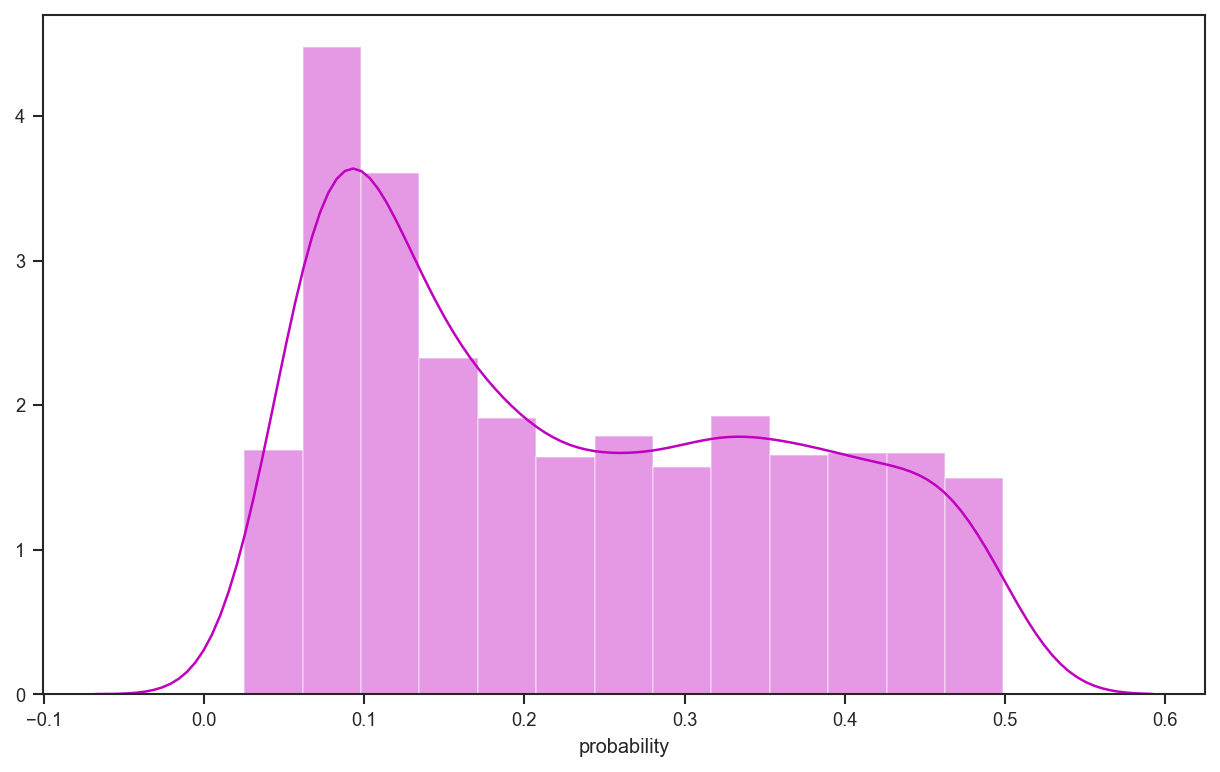

In [13]:
p11 = sin[sin.prediction == 1.0].probability
sns.distplot(p11,  hist=True, color="m")

In [14]:
p11.describe()

count    2237.000000
mean        0.229163
std         0.136765
min         0.025000
25%         0.104000
50%         0.200000
75%         0.345000
max         0.499000
Name: probability, dtype: float64

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [30]:
y_test = cp_2018.label
y_pred = cp_2018.prediction
cm = confusion_matrix(y_test, y_pred)

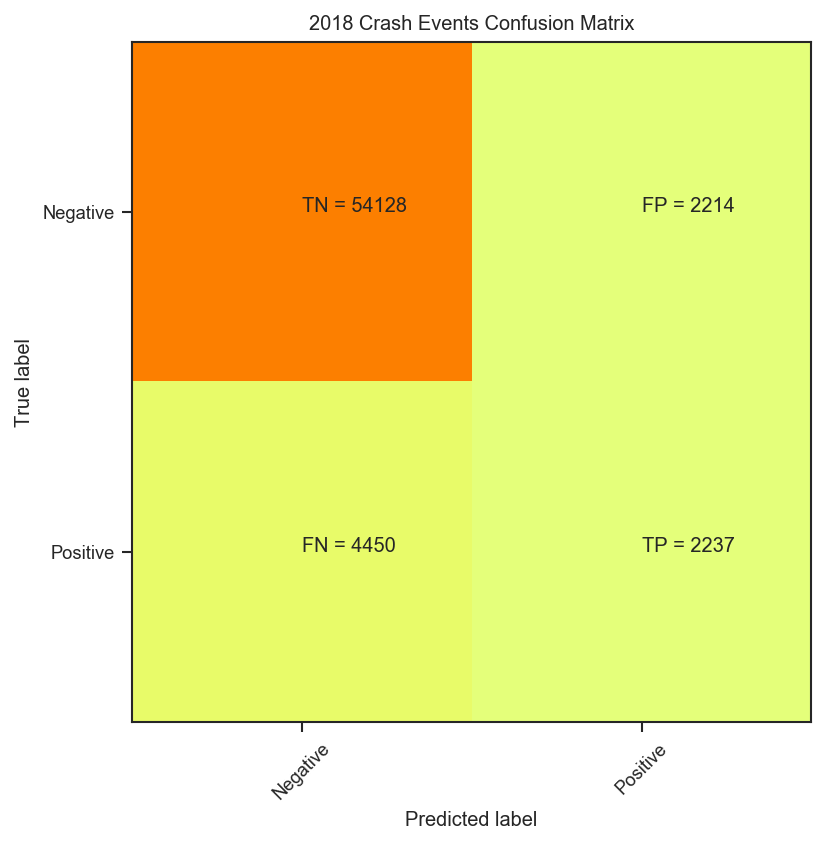

In [29]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('2018 Crash Events Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     56342
         1.0       0.50      0.33      0.40      6687

    accuracy                           0.89     63029
   macro avg       0.71      0.65      0.67     63029
weighted avg       0.88      0.89      0.88     63029

